<a href="https://colab.research.google.com/github/rrl7012005/Tensor-Flow-Computer-Vision-Course/blob/main/Digits_and_Face_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoders

These are generative models which generate images in this case that are from a similar distribution as the original images.

Traditional autoencoders have 2 components, an encoder maps the input data X into a lower dimensional latent space Z. Then a decoder reconstructs the original input from this compressed latent space. These autoencoders do not generate samples, VAEs however are a probabilistic version of autoencoders. Each input (not the whole set) is encoded as a distribution (mean and variance), allowing the model to generate new samples by sampling from this learned space. The encoder outputs a mean and variance for each dimension in the latent space, a random vector z is sampled from this latent space distribution using the reparamterization trick (z = mu + sig*eps) where eps follows a standard normal, this ensures the model can be trained using standard backpropagation. The goal of VAE compared to traditional autoencoders is to generate a smooth latent space representation.

So there is 3 parts: encoder network, sampling layer, decoder network. The loss functon combines the KL Divergence Loss from the learned distirbution and the standard normal distribution to ensure the learned distribution is close to the true prior distribution, and the reconstruction loss which measures how well the decoder reconstructs the input data from z (this is the MSE or cross-entropy) typically.  

L
recon
​
 =−E
q(z∣x)
​
 [logp(x∣z)]


 L
KL
​
 =D
KL
​
 (q(z∣x)∥p(z))


 VAEs can be used for image generation, data augmentation, data imputation, and anomaly detection

An example of encoding is suppose you have an image of a face, some latent attributes may be the distribution of smile, amount of skin tone, gender, beard etc. Each image can be encoded in terms of some learnt latent attributes. VAE finds the distribution of the latent attributes. Autoencoding can be used for image compression as the latent space is lower dimensional, or for image searching as well by comparing the latent representations for similar images.

##Data Preparation

For our VAE, we will generate digits using the MNIST dataset as our training set. Discard the labels and then what we do is to concatenate the training and testing set. We're doing an unsupervised method

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255 #Normalize and add channel dim

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)
len(dataset)

70000

In [ ]:
BATCH_SIZE = 128
LATENT_DIM = 2 #dim for each mean and var
train_dataset = (dataset.
                 shuffle(buffer_size=1024, reshuffle_each_iteration=True).
                 batch(BATCH_SIZE).
                 prefetch(tf.data.AUTOTUNE))

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

##Encoder

Lets create the sampling layer to sample from a distribution

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5 * log_var) * tf.random.normal(shape=(tf.shape(log_var)[0], tf.shape(log_var)[1]))

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(28, 28, 1))

x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)

mean = tf.keras.layers.Dense(LATENT_DIM)(x)

#std can be close to 0, if we use relu finding derivatices will lead to numerical instability
#so use log so the values can take a larger range (stable training)
#its a projection so linear activation
log_var = tf.keras.layers.Dense(LATENT_DIM)(x)

#Sample z layer
z = Sampling()([mean, log_var]) #multiple inps

encoder_model = tf.keras.models.Model(encoder_inputs, [z, mean, log_var], name='encoder')

encoder_model.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 3136)           │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 16)             │         50,192 │ flatten_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 2)              │             34 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 2)              │             34 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_2 (Sampling)     │ (None, 2)              │              0 │ dense_9[0][0],         │
│                           │                        │                │ dense_10[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

##Decoder

We need to upsample from this latent space, but we have only down sampled so far, never upsampled. What we first do is we pass through a dense layer with the exact number of neurons required, then we reshape, and then we pass through a Conv Transpose layer. The conv transpose layer, upsamples inputs. It works the same way just add some padding, expand the pixels onto a larger area and do convolution the other way.

We want to upsample to 7,7,64 so then we can go to 14, 14, 32 and then 28x28x1 output

In [ ]:
latent_inputs = tf.keras.layers.Input(shape=(LATENT_DIM, ))

x = tf.keras.layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)

x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

#sigmoid activation as gray scale output so values fall between 0 and 1
decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder_model = tf.keras.models.Model(latent_inputs, decoder_outputs, name='decoder')

decoder_model.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

##Modelling and Training

Lets create the overall model which combines the encoder and decoder.

In [ ]:
vae_input = tf.keras.layers.Input(shape=(28, 28, 1))
z, _, _ = encoder_model(vae_input)
reconstructed = decoder_model(z)

vae = tf.keras.models.Model(vae_input, reconstructed, name='vae')
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ [(None, 2), (None, 2),      │          69,076 │
│                                      │ (None, 2)]                  │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │          65,089 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,165 (524.08 KB)

 Trainable params: 134,165 (524.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i in range(3):
  print(vae.layers[i])

<InputLayer name=input_layer_8, built=True>
<Functional name=encoder, built=True>
<Functional name=decoder, built=True>


**Training**

We will use the adam optimizer with lr 1e-3

In [ ]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate = 1e-3)
EPOCHS = 10

We need to create our custom loss functions which combine the reconstruction loss with the KL Divergence (also called the regularization loss).

For the reconstruction loss, the true value is the input, the predicted is the output. Each pixel gives a bce value so we need to sum over all positions (axes 1 and 2) (not over the batch dim) then we take the mean over the batch dim

In [ ]:
def custom_loss(y_true, y_pred, mean, log_var):
  loss_recons = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  #reduce the reg loss as before axis 1 because loss_reg is (B, D)
  return loss_recons + tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

We need to build our own training loop, as for one we are doing an unsupervised method where the true value we are comparing against is the input so we need to modify how the process is done.

In [ ]:
@tf.function #graph mode
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    #track grads

    z, mean, log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true, y_pred, mean, log_var)

  grads = recorder.gradient(loss, vae.trainable_weights)
  OPTIMIZER.apply_gradients(zip(grads, vae.trainable_weights))

  return loss

In [ ]:
def training(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, x_batch in enumerate(train_dataset):
      loss = training_block(x_batch)

    print('Training Loss is: ', loss)

  print('Training Complete!!!')

In [ ]:
# training(EPOCHS)

Can also create a class and override the built in train step method, this way you can run the model tensorflow normally does with the progress bars, time steps loss displays etc. Custom training loops give you more freedom than pre-used loops, below we can combine the best of both worlds by redefining the training step.

In [ ]:
class VAE(tf.keras.Model):
  def __init__(self, encoder_model, decoder_model):
    super(VAE, self).__init__()
    self.encoder = encoder_model
    self.decoder = decoder_model
    self.loss_tracker = tf.keras.metrics.Mean(name='loss')

  @property
  def metrics(self):
    return [self.loss_tracker]

  def train_step(self,x_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var = encoder_model(x_batch)
      y_pred = decoder_model(z)
      y_true = x_batch
      loss = custom_loss(y_true,y_pred, mean, log_var)

    partial_derivatives = recorder.gradient(loss,self.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [ ]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=EPOCHS, batch_size=128)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 266.5659
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 177.1768
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 167.2029
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 162.2870
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 159.5622
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 157.7797
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 156.5457
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 155.5248
Epoch 9/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 154.7412
Epoch 10/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 153.9587


##Testing

Our VAE generates images from the latent representations, with a decoder. If we want a random image to be generated, we pass a random z value into the deocder and get the generated input

In [ ]:
scale = 1
n = 16 #subplot size

#Use as our z values
grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

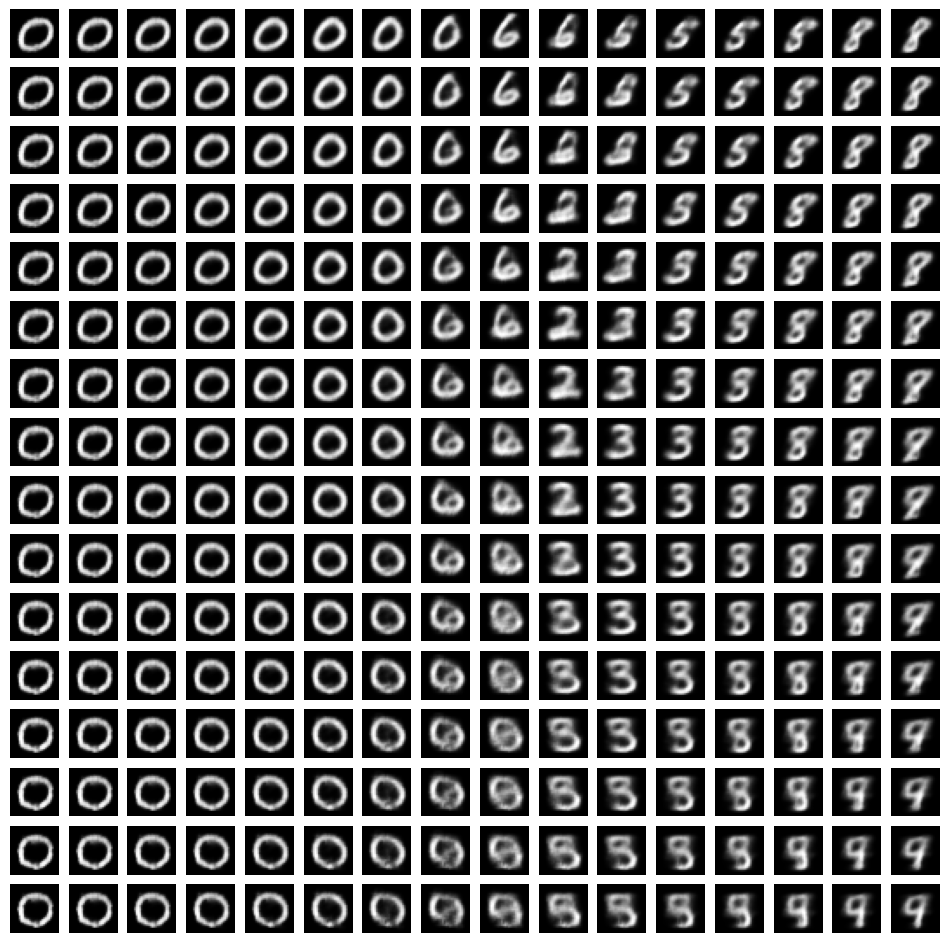

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
k = 0
for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n, n, k+1)

        z_sample = tf.constant([[i, j]]) #batch dim
        x_decoded = model.decoder.predict(z_sample)[0][..., 0] #remove batch and channel dim
        plt.imshow(x_decoded, cmap='gray')
        plt.axis('off')
        k += 1

Left hand side and upper hand side of grid is values of -1, and right hand side and lower half is values closer to 1

You can see how the latent values change, the different numbers we get showing how each number has its own latent space representation.

Now lets visualize the latent space itself. Effectively a dimensionality reduction from the larger space. We'll include the labels as well

In [ ]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
mnist_digits = np.expand_dims(x_train,-1).astype("float32") / 255 #channel dim

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


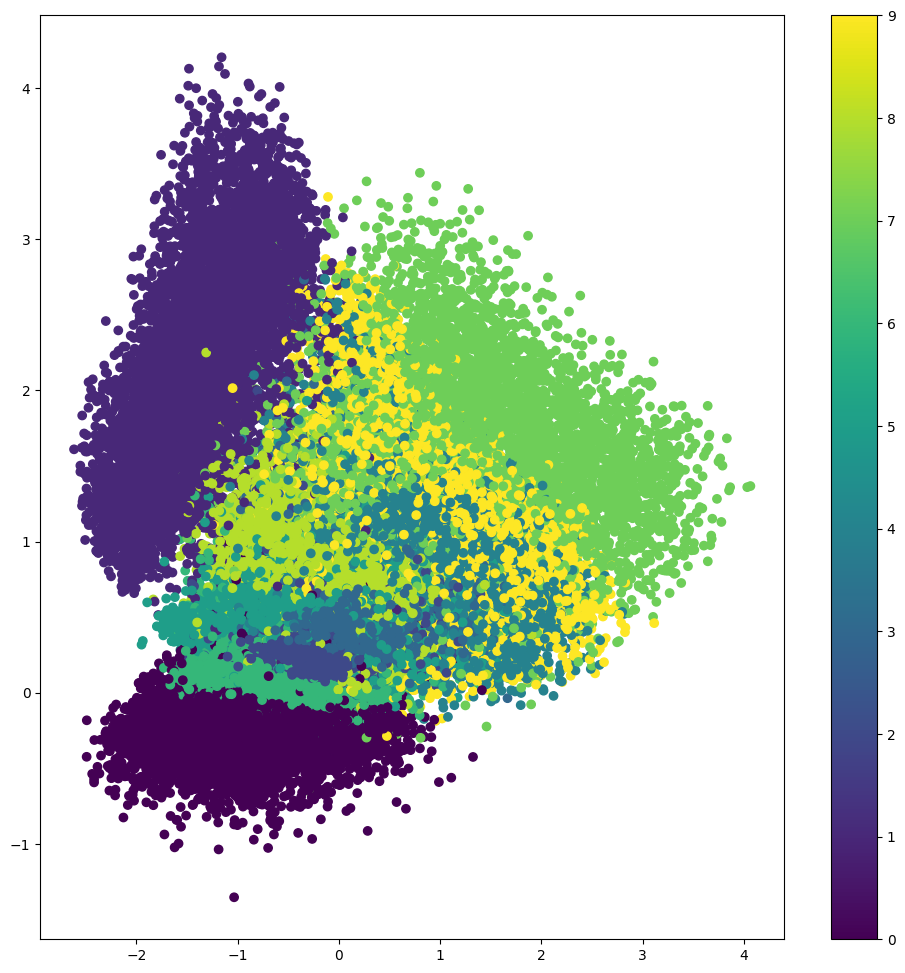

In [ ]:
z, _, _ = model.encoder.predict(mnist_digits)
plt.figure(figsize=(12, 12))
plt.scatter(z[:, 0], z[:, 1], c=y_train) #digits with same label have same color
plt.colorbar()
plt.show()

The VAE has essentially been trained to identify clusters.

#Generator Adversarial Networks

This is composed of a generator and discriminator. Again the goal is to generate information in the similar distribution as the training set.

The generator takes a random noise vector (sampled from a normal usually), and transforms it through its network into a synthetic image. The discriminator is a binary classifier that classifies that receives real samples from the training data and fake samples from the generator, and identifies if input sampe is real or fake. The goal is for the generator to fool the discriminator i.e generate images that come from similar distribution as the training set, so the parameters of the network will adjust to that. The discriminator also tries to become better at detecting fake data, so parameters will adjust to that, so we get even better images generated.

The generator tries to maximize probability the discriminator incorrectly classifies a sample as real, the discirminator tries to maximize the probability of correctly classifying samples.

The discriminator loss (maximize classifying real samples and minimize probs of classifying fake samples)

−E
x∼p
data
​

​
 [logD(x)]−E
z∼p
z
​

​
 [log(1−D(G(z)))]

 D(x) is discriminator output for real sample x, G(z) is generator output for a random noise z. Generator loss is

 −E
z∼p
z
​

​
 [logD(G(z))]


 We first train the discriminator, and then train the generator. DCGANs (Deep convolutional) uses convolutional layers instead of fully contected layers. Any pooling is done with strided convolutions in the discriminator and fractional strided convolutions in the generator. Batch norm is used in generator and discriminator. Relu everwyhere but tamh in output. Use LeakyRelu for discriminator everywhere.

 Its difficult to make GANs work, look at the guide on tips and tricks to make GANs work. One thing we can do is normalize inputs. Another thing is to modify loss function of generator where instead of doing min log(1 - D(x)) we do max log(D(x)) its equivalent. At the start of training its difficult for discriminator to generate 1 as GANS cannot fool the discriminator, this leads to a vanishing gradient problem with the previous loss function. Another tip is to sample from a gaussian instead of a uniform distribution for the noise. Training GANs are very very difficult, theres more tips online on a github somewhere.

We are building a face generation from a distribution of face images.

#DCGAN

##Data Processing

In [ ]:
import tensorflow as tf
import numpy as np
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/jessicali9530/celeba-dataset')

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset


100%|██████████| 1.33G/1.33G [00:20<00:00, 69.4MB/s]


In [ ]:
BATCH_SIZE = 128
IM_SHAPE = (64, 64, 3)
LEARNING_RATE = 2e-4
LATENT_DIM = 100
EPOCHS = 20

Obtain a tensorflow dataset using image dataset from directory.

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/celeba-dataset/img_align_celeba/img_align_celeba", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE
)

Found 202599 files.


There are 200000 images

In [ ]:
dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

We need to normalize our data so it lies between -1 and 1

In [ ]:
def preprocess(image):
  return tf.cast(image, tf.float32) / 127.5 - 1.0

In [ ]:
train_dataset = (
    dataset.
    map(preprocess).
    unbatch().
    shuffle(buffer_size=1024, reshuffle_each_iteration=True).
    batch(BATCH_SIZE, drop_remainder=True).
    prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for d in train_dataset.take(1):
  print(d.shape)

(128, 64, 64, 3)


Plot some faces, note we need to get our images in the range 0 to 1 so we add 1 and then divide 2

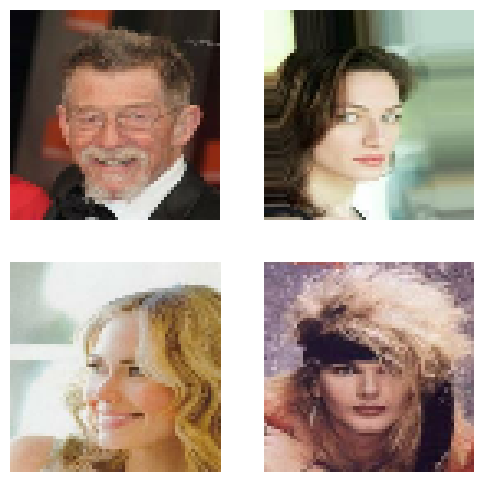

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize= (6, 6))
k = 0
n = 4
for i in range(n):
  ax = plt.subplot(2, 2, k+1)
  plt.imshow((d[k] + 1) / 2)
  plt.axis('off')
  k += 1

##Modelling

First we build the generator, our latent dimension is 100 to capture a lot of features

In [ ]:
generator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(LATENT_DIM,)),
    tf.keras.layers.Dense(4 * 4 * LATENT_DIM), #Project for image size
    tf.keras.layers.Reshape((4, 4, LATENT_DIM)),

    #Upsampling convolutional layer
    tf.keras.layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', activation=tf.keras.activations.tanh)
], name= 'generator')

generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1600)                │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 512)           │         819,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 64, 64, 3)           │           6,147 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,612,867 (13.78 MB)

 Trainable params: 3,611,075 (13.78 MB)

 Non-trainable params: 1,792 (7.00 KB)

Now we build the discriminator

In [ ]:
discriminator = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IM_SHAPE[0], IM_SHAPE[1], 3)),

    tf.keras.layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2D(128, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2D(256, kernel_size=4, strides=2, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Conv2D(1, kernel_size=4, strides=2, padding='same'),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1, activation='sigmoid')
], name='discriminator')

discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 1)             │           4,097 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 664,530 (2.53 MB)

 Trainable params: 663,762 (2.53 MB)

 Non-trainable params: 768 (3.00 KB)

Lets create our custom training loop and thus the whole model (we override the train step). This is pretty self explanatory if you know GANs, just go through it.

In [ ]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile() #inherit from the original compile func
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
    self.d_loss_metric=tf.keras.metrics.Mean(name='d_loss')
    self.g_loss_metric=tf.keras.metrics.Mean(name='g_loss')

  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))

    fake_images = self.generator(random_noise)

    #smooth labels so its softer
    real_labels = tf.ones((batch_size, 1)) + 0.25 * tf.random.uniform((batch_size, 1), minval=-1, maxval=1)
    fake_labels = tf.zeros((batch_size, 1)) + 0.25 * tf.random.uniform((batch_size, 1))

    #Discriminator

    with tf.GradientTape() as recorder:
      real_predictions = self.discriminator(real_images)

      d_loss_real = self.loss_fn(real_labels, real_predictions)

      fake_predictions = self.discriminator(fake_images)

      d_loss_fake = self.loss_fn(fake_labels, fake_predictions)

      d_loss = d_loss_real + d_loss_fake

    grads = recorder.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    #Generator

    random_noise = tf.random.normal(shape=(batch_size, LATENT_DIM))

    flipped_fake_labels = tf.ones((batch_size, 1))

    with tf.GradientTape() as recorder:
      fake_predictions = self.discriminator(self.generator(random_noise))

      g_loss = self.loss_fn(flipped_fake_labels, fake_predictions)

    grads = recorder.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    return {'d_loss': self.d_loss_metric.result(),
            'g_loss': self.g_loss_metric.result()}


Compile and for our loss we will use binary cross entropy.

In [ ]:
gan = GAN(discriminator,generator)
gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy())

We need to log the generated images in a file, so lets use a callback to log images during the training process

In [ ]:
class ShowImage(tf.keras.callbacks.Callback):
  def __init__(self, latent_dim=100):
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_noise = tf.random.normal(shape=(36, self.latent_dim))
    generated_images = self.model.generator(random_noise)
    n, k = 6, 0
    plt.figure(figsize=(12, 12))
    for i in range(n):
      for j in range(n):
        ax = plt.subplot(n, n, k+1)
        plt.imshow((generated_images[k] + 1) / 2)
        plt.axis('off')
        k += 1

    plt.savefig(f"generated/gen_images_epoch_{epoch + 1}.png")

RUN

In [ ]:
!mkdir generated

In [ ]:
EPOCHS = 100
history = gan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[ShowImage(latent_dim=LATENT_DIM)]
)

Epoch 1/100
   1582/Unknown 303s 178ms/step - d_loss: 1.0785 - g_loss: 1.2261

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 305s 179ms/step - d_loss: 1.0786 - g_loss: 1.2260
Epoch 2/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 308s 179ms/step - d_loss: 1.1688 - g_loss: 1.1113
Epoch 3/100
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 283s 178ms/step - d_loss: 1.1935 - g_loss: 1.0712
Epoch 4/100
 762/1582 ━━━━━━━━━━━━━━━━━━━━ 2:27 180ms/step - d_loss: 1.2044 - g_loss: 1.0421

Plot the losses

In [ ]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])
plt.title('GAN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['d_loss', 'g_loss'], loc='upper left')
plt.show()

Visualize the generated images

In [ ]:
import cv2

epoch_num = 3

filename = f'generated/gen_images_epoch_{epoch_num}.png'
img = cv2.imread(filename)
plt.title(f'{epoch_num} Images Generated')
plt.imshow(img)